## Backtesting Bollinger Bands strategy for EUR/USD Currency pairs

##### Description: Historical Data of EUR/USD is collected from 2018 to 2023 and backtested using Bollinger Bands Strategy against Buy and Hold strategy.

In [2]:
#import all necessary librabries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import pandas_datareader.data as web
import os

In [3]:
pip install pyfolio # installing pyfolio

     ---------------------------------------- 91.1/91.1 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 52.8/52.8 kB 905.3 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88677 sha256=19abec36a3f5de5e19c6f79dcac9329e0a30591e23137c33290b1e9ed28881ce
  Stored in directory: c:\users\rayu0\appdata\local\pip\cache\wheels\75\c7\b9\986a1ba8adb2afce230e1a497dc11aeb33efef4fc8dfd6c649
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39775 sha256=a0202a7a9d6c3e82f7c69313baabfab07c64ab0aaea5e37fec543325c6008f8e
  Stored in directory: c:\users\rayu0\appdata\local\pip\cache\wheels\67\23\d1\a4ef8ff88dc9af7b0eeb1b6fd0d90c6057eaad5a2df25f4e3f
Successfully built pyfolio empyrical
Note: you may need to restart the

In [5]:
import warnings

In [6]:
warnings.filterwarnings('ignore') #ignore printing warning messages

In [8]:
from IPython.core.interactiveshell import InteractiveShell  #To print output
InteractiveShell.ast_node_interactivity = "all"

In [20]:
#downloading necessary historical data of EUR/USD
Tstart = dt.date(2018,1,1)
Tend = dt.date(2023,5,1)
ticker = 'EURUSD=X'
df = yf.download(ticker, start = Tstart, end = Tend)

[*********************100%***********************]  1 of 1 completed


In [21]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,1.200495,1.201504,1.199904,1.200495,1.200495,0
2018-01-02,1.201086,1.208094,1.200855,1.201158,1.201158,0
2018-01-03,1.206200,1.206709,1.200495,1.206345,1.206345,0
2018-01-04,1.201129,1.209190,1.200495,1.201043,1.201043,0
2018-01-05,1.206622,1.208459,1.202154,1.206884,1.206884,0


In [22]:
# calculating returns using buy and hold strategy
df['bnh_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))

In [23]:
df['bnh_returns']

Date
2018-01-01         NaN
2018-01-02    0.000552
2018-01-03    0.004309
2018-01-04   -0.004406
2018-01-05    0.004852
                ...   
2023-04-24    0.001944
2023-04-25    0.006097
2023-04-26   -0.007361
2023-04-27    0.006255
2023-04-28   -0.001380
Name: bnh_returns, Length: 1389, dtype: float64

In [24]:
#creating bollinger strategy indicators
df['ma20'] = df['Adj Close'].rolling(window=20).mean()
df['std'] = df['Adj Close'].rolling(window=20).std()
df['upper_band'] = df['ma20'] + (2 * df['std'])
df['lower_band'] = df['ma20'] - (2 * df['std'])
df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
df.tail(5)

,Close,Adj Close,Volume,bnh_returns,ma20,std,upper_band,lower_band
Date,,,,,,,,
2023-04-24,1.099227,1.099227,0,0.001944,1.092259,0.006658,1.105574,1.078943
2023-04-25,1.105950,1.105950,0,0.006097,1.093521,0.006745,1.107010,1.080031
2023-04-26,1.097839,1.097839,0,-0.007361,1.094215,0.006415,1.107044,1.081386
2023-04-27,1.104728,1.104728,0,0.006255,1.095233,0.006385,1.108003,1.082464
2023-04-28,1.103205,1.103205,0,-0.001380,1.095870,0.006518,1.108907,1.082834


In [25]:
# Buy strategy conditions
df['signal'] = np.where((df['Adj Close'] < df['lower_band']) &
                        (df['Adj Close'].shift(1) >= df['lower_band']),1,0)

# Sell strategy conditions
df['signal'] = np.where( (df['Adj Close'] > df['upper_band']) &
                          (df['Adj Close'].shift(1) <= df['upper_band']),-1,df['signal'])
# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])

df.tail(5)

,Close,Adj Close,Volume,bnh_returns,ma20,std,upper_band,lower_band,signal,position,strategy_returns
Date,,,,,,,,,,,
2023-04-24,1.099227,1.099227,0,0.001944,1.092259,0.006658,1.105574,1.078943,0,-1.0,-0.001944
2023-04-25,1.105950,1.105950,0,0.006097,1.093521,0.006745,1.107010,1.080031,0,-1.0,-0.006097
2023-04-26,1.097839,1.097839,0,-0.007361,1.094215,0.006415,1.107044,1.081386,0,-1.0,0.007361
2023-04-27,1.104728,1.104728,0,0.006255,1.095233,0.006385,1.108003,1.082464,0,-1.0,-0.006255
2023-04-28,1.103205,1.103205,0,-0.001380,1.095870,0.006518,1.108907,1.082834,0,-1.0,0.001380


Buy and hold returns: -82.92104607900785
Strategy returns: 111.09988185531056


<AxesSubplot:xlabel='Date'>

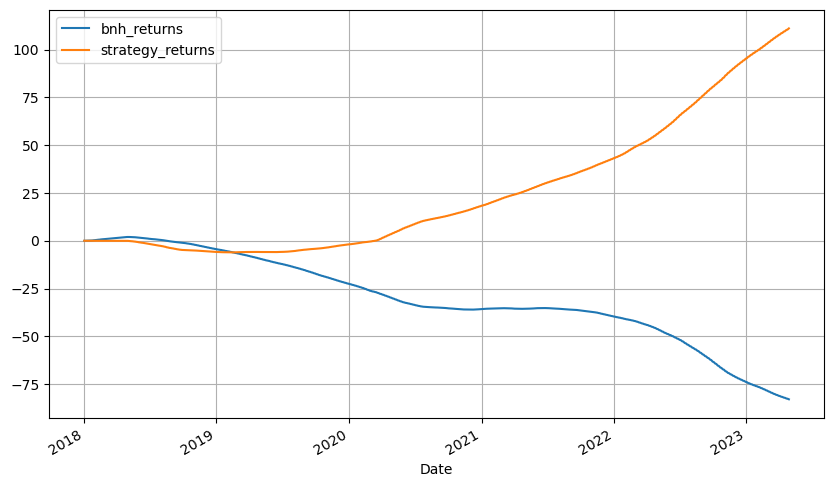

In [30]:
# comparing buy & hold strategy returns with bollinger bands strategy returns
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(10, 6))

In [27]:
import pyfolio as pf

Start date,2018-01-01
End date,2023-04-28
Total months,66
,Backtest
Annual return,2.8%
Cumulative returns,16.2%
Annual volatility,7.1%
Sharpe ratio,0.42
Calmar ratio,0.23
Stability,0.85
Max drawdown,-12.0%


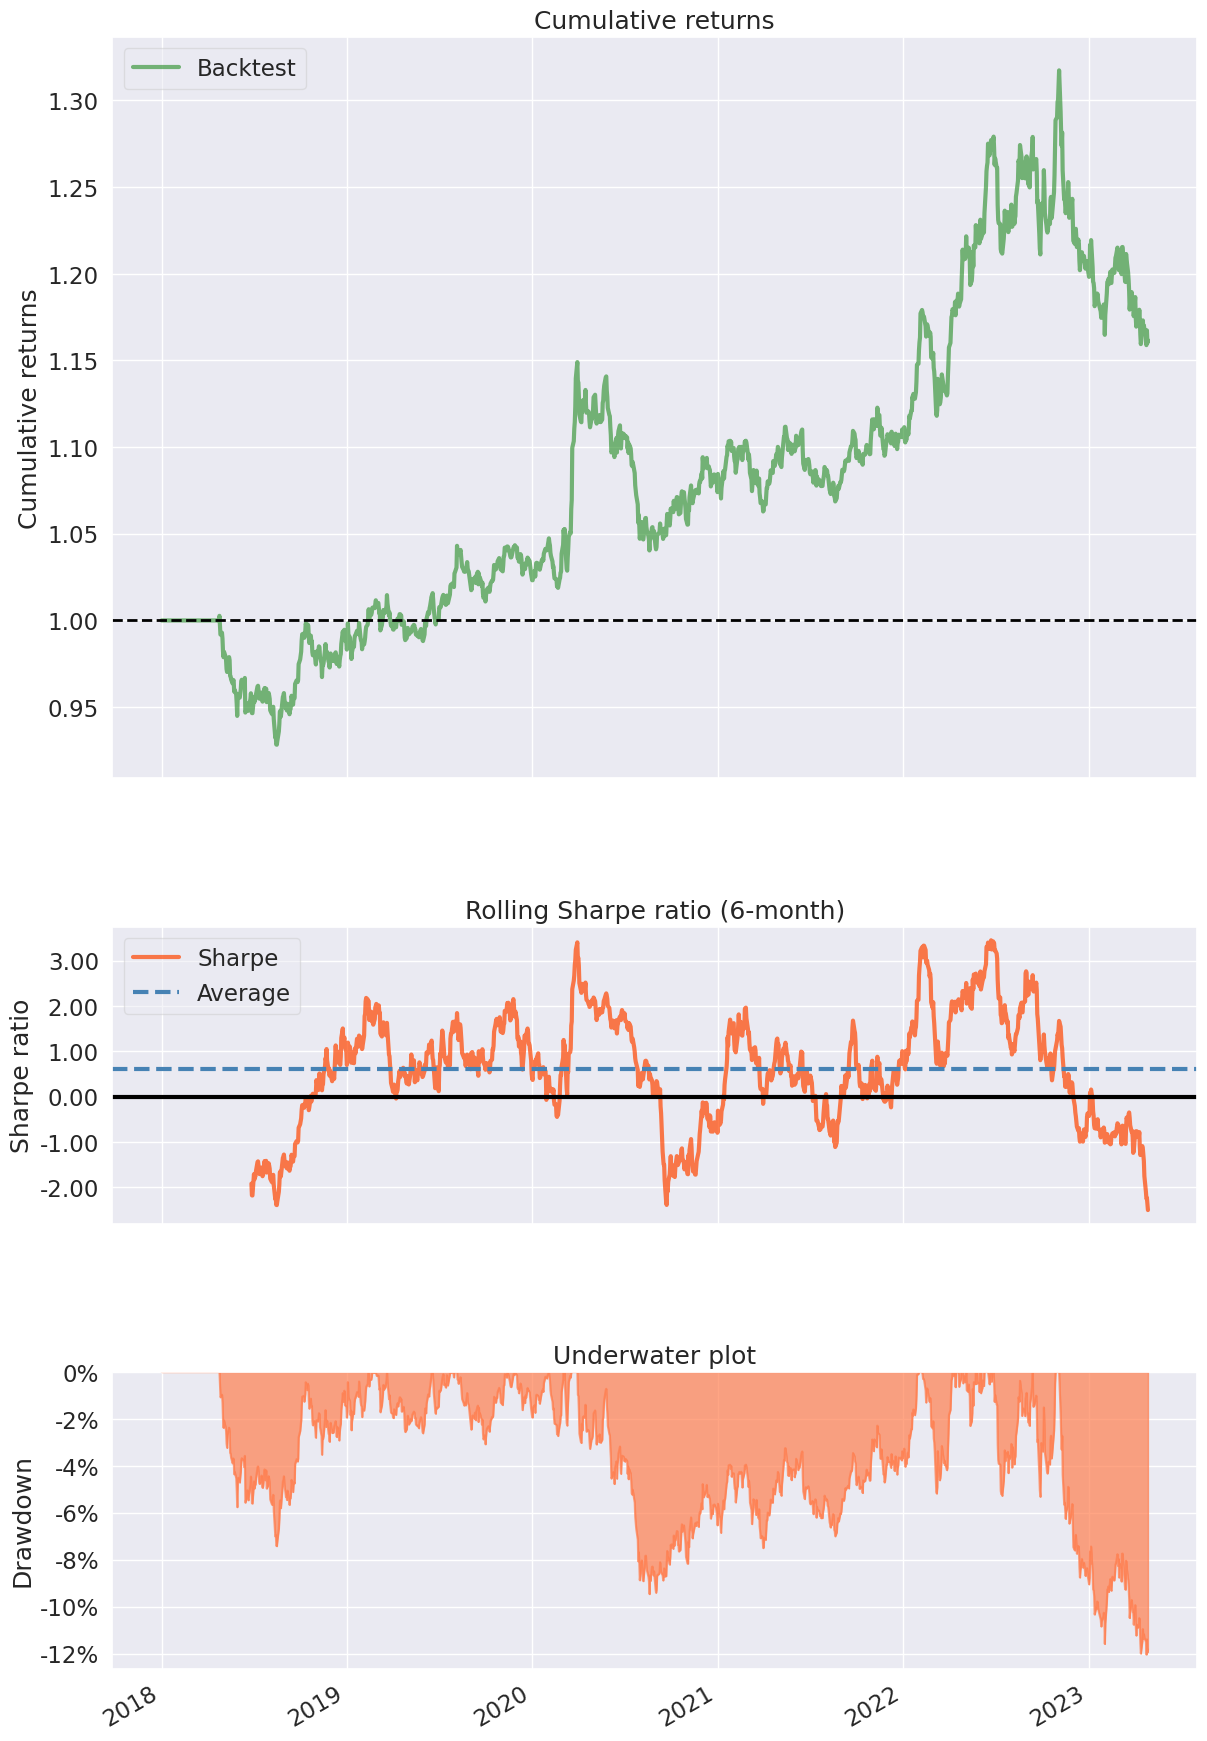

In [28]:
pf.create_simple_tear_sheet(df['strategy_returns'].diff())

# Conclusion

#### Bollinger strategy would be preferred as it yields an average return of 0.16375377485252152 against a return of -0.0845142372059601 when buy and hold strategy is used

#### The results could be different if the same two strategies were compared against a company stock.